# 2D CNN classification of images of MFCCs

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import shutil
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import time
from keras.utils import np_utils
from keras import backend as K
from sklearn.manifold import TSNE
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

nb_class = 3

Using TensorFlow backend.


In [ ]:
path_dcase2017_dev = 'data/TUT-acoustic-scenes-2017-development'
path_dcase2017_eval = 'data/TUT-acoustic-scenes-2017-evaluation'
path_dcase2017_data = os.path.join(path_dcase2017_dev, 'audio')
path_dcase2017_data_final = os.path.join(path_dcase2017_eval, 'audio')
path_evaluation_setup = os.path.join(path_dcase2017_dev, 'evaluation_setup')
path_fold1_train_txt = os.path.join(path_evaluation_setup, 'fold1_train.txt')
path_fold1_validation_txt = os.path.join(path_evaluation_setup, 'fold1_evaluate.txt')
path_evaluation_setup_final = os.path.join(path_dcase2017_eval,'evaluation_setup')
path_final_txt = os.path.join(path_evaluation_setup_final,'evaluate.txt')

## Training dataset

In [ ]:
train = pd.read_csv(path_fold1_train_txt, sep='\t', names=['file', 'scene'], 
                    converters={'file': lambda s: s.replace('audio/', '')})

validation = pd.read_csv(path_fold1_validation_txt, sep='\t', names=['file', 'scene'], 
                         converters={'file': lambda s: s.replace('audio/', '')})

In [ ]:
train['scene'] = train['scene'].replace(['beach', 'city_center', 'forest_path', 'park', 'residential_area'], 
                                        ['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor'])

train['scene'] = train['scene'].replace(['bus', 'car', 'train', 'tram'], 
                                        ['vehicle', 'vehicle', 'vehicle', 'vehicle'])

train['scene'] = train['scene'].replace(['cafe/restaurant', 'grocery_store', 'home', 'library', 'metro_station',
                                        'office'], ['indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor'])

In [ ]:
print("The size of training dataset is:", len(train), "recordings")
lab = pd.unique(train['scene'])
print(lab)

In [ ]:
for folder in lab:
    directory = 'audio/train/fold1/'
    os.makedirs(os.path.join(directory, str(folder)), exist_ok=True)

train_file = train['file'].to_dict()

In [ ]:
for path, subdirs, files in os.walk(path_dcase2017_data):
    for file in tqdm(files):
        if file in train_file.values():
            directory = 'audio/train/fold1/'
            folder = train.loc[train['file'] == file]['scene'].get_values()[0]
            directory = directory + str(folder)
            shutil.copy(path + "/" + file, directory)

## Validation dataset

In [ ]:
validation['scene'] = validation['scene'].replace(['beach', 'city_center', 'forest_path', 'park', 
                                                   'residential_area'], 
                                                  ['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor'])

validation['scene'] = validation['scene'].replace(['bus', 'car', 'train', 'tram'], 
                                                  ['vehicle', 'vehicle', 'vehicle', 'vehicle'])

validation['scene'] = validation['scene'].replace(['cafe/restaurant', 'grocery_store', 'home', 
                                                   'library', 'metro_station', 'office'], 
                                                  ['indoor', 'indoor', 'indoor', 'indoor', 'indoor', 'indoor'])

In [ ]:
print("The size of validation dataset is:", len(validation), "recordings")
lab_val = pd.unique(validation['scene'])
print(lab_val)

In [ ]:
for folder in lab_val:
    directory = 'audio/validation/fold1/'
    os.makedirs(os.path.join(directory, str(folder)), exist_ok=True)

validation_file = validation['file'].to_dict()

In [ ]:
for path, subdirs, files in os.walk(path_dcase2017_data):
    for file in tqdm(files):
        if file in validation_file.values():
            directory = 'audio/validation/fold1/'
            folder = validation.loc[validation['file'] == file]['scene'].get_values()[0]
            directory = directory + str(folder)
            shutil.copy(path + "/" + file, directory)

In [ ]:
train_wavs = 'audio/train/fold1'
validation_wavs = 'audio/validation/fold1'

In [ ]:
train_mfcc_features = []
train_labels = []
for path, subdirs, files in os.walk(train_wavs):
    for file in tqdm(files):
        path = path.replace(train_wavs, "")
        y, _ = librosa.load(train_wavs + "/" + path + "/" + file, mono=True, sr=44100)
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=13, n_fft=2048, hop_length=1024)
        train_mfcc_features.append(mfccs)
        train_labels.append(path.replace("/", ""))

In [ ]:
print(np.shape(train_mfcc_features))
print(np.shape(train_labels))

In [ ]:
np.save('train_mfccs.npy', train_mfcc_features)
np.save('train_labels.npy', train_labels)

In [ ]:
validation_mfcc_features = []
validation_labels = []
for path, subdirs, files in os.walk(validation_wavs):
    for file in tqdm(files):
        path = path.replace(validation_wavs, "")
        y, _ = librosa.load(validation_wavs + "/" + path + "/" + file, mono=True, sr=44100)
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=13, n_fft=2048, hop_length=1024)
        validation_mfcc_features.append(mfccs)
        validation_labels.append(path.replace("/", ""))

In [ ]:
print(np.shape(validation_mfcc_features))
print(np.shape(validation_labels))

In [ ]:
np.save('validation_mfccs.npy', validation_mfcc_features)
np.save('validation_labels.npy', validation_labels)

In [ ]:
validation_mfcc_features[1].shape

In [ ]:
# outdoor class
librosa.display.specshow(validation_mfcc_features[1], x_axis='time')
plt.show()

In [ ]:
# indoor class
librosa.display.specshow(validation_mfcc_features[1160], x_axis='time')
plt.show()

In [ ]:
plt.plot(validation_mfcc_features[1])
plt.show()

In [2]:
train_mfcc_features = np.load('train_mfccs.npy')
validation_mfcc_features = np.load('validation_mfccs.npy')

train_labels = np.load('train_labels.npy')
validation_labels =np.load('validation_labels.npy')

train_label_encoder = LabelEncoder().fit(train_labels)
train_labels = train_label_encoder.transform(train_labels)
classes_train = list(train_label_encoder.classes_)

In [3]:
classes_train

['indoor', 'outdoor', 'vehicle']

In [4]:
len(train_labels)

3510

In [5]:
train_scaled = []
for i in range(len(train_mfcc_features)):
    scaler_train = StandardScaler().fit(train_mfcc_features[i])
    scaled_train = scaler_train.transform(train_mfcc_features[i])
    train_scaled.append(scaled_train)

In [6]:
validation_label_encoder = LabelEncoder().fit(validation_labels)
validation_labels = validation_label_encoder.transform(validation_labels)
classes_validation = list(validation_label_encoder.classes_)

In [7]:
classes_validation

['indoor', 'outdoor', 'vehicle']

In [8]:
len(validation_labels)

1170

In [9]:
validation_scaled = []
for i in range(len(validation_mfcc_features)):
    scaler_validation = StandardScaler().fit(validation_mfcc_features[i])
    scaled_validation = scaler_validation.transform(validation_mfcc_features[i])
    validation_scaled.append(scaled_validation)

In [10]:
X_train = train_scaled
y_train = np_utils.to_categorical(train_labels)

X_val = validation_scaled
y_val = np_utils.to_categorical(validation_labels)

In [11]:
# 2D convolution parameters

NB_ROWS = 13     # corresponds to number of mfccs
NB_COLS = 431    # correponds to the size of mfccs[i] (one mfcc)
CHANNEL = 1      # the number of channels

In [12]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [13]:
# Reshaping to perform 2D convolution
X_train_2D_cnn = X_train.reshape(X_train.shape[0], NB_ROWS, NB_COLS, CHANNEL)
X_test_2D_cnn = X_val.reshape(X_val.shape[0], NB_ROWS, NB_COLS, CHANNEL)

y_train_2D_cnn_hot = y_train
y_test_2D_cnn_hot = y_val

print("[INFO] X_train_2D_cnn.shape = {}, y_train_2D_cnn_hot.shape = {} ".format(X_train_2D_cnn.shape, y_train_2D_cnn_hot.shape))
print("[INFO] X_test_2D_cnn.shape = {}, y_test_2D_cnn_hot.shape = {} ".format(X_test_2D_cnn.shape, y_test_2D_cnn_hot.shape))

[INFO] X_train_2D_cnn.shape = (3510, 13, 431, 1), y_train_2D_cnn_hot.shape = (3510, 3) 
[INFO] X_test_2D_cnn.shape = (1170, 13, 431, 1), y_test_2D_cnn_hot.shape = (1170, 3) 


In [14]:
# debug
print("[DEBUG] y_train_2D_cnn_hot.shape = {}, y_train_2D_cnn_hot[0] = {}".format(y_train_2D_cnn_hot.shape, y_train_2D_cnn_hot[0]))
print("[DEBUG] y_test_2D_cnn_hot.shape = {}, y_test_2D_cnn_hot[0] = {}".format(y_test_2D_cnn_hot.shape, y_test_2D_cnn_hot[0]))

[DEBUG] y_train_2D_cnn_hot.shape = (3510, 3), y_train_2D_cnn_hot[0] = [0. 1. 0.]
[DEBUG] y_test_2D_cnn_hot.shape = (1170, 3), y_test_2D_cnn_hot[0] = [0. 1. 0.]


In [15]:
def construct_model(input_shape=(13, 431, 1), num_classes = 3):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax', name="output_layer"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
epochs = 30
batch_size = 32
verbose = 1
num_classes = 3
input_shape = (NB_ROWS, NB_COLS, CHANNEL)

outputFolder = "model"

# Create the model and fit it
start = time.time()
model = construct_model(input_shape=input_shape, num_classes=num_classes)
filepath = outputFolder + "/fold1-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

earlystop = EarlyStopping(monitor='val_acc', patience=5,
                          verbose=verbose, mode='auto')

callbacks_list = [checkpoint, earlystop]
history = model.fit(X_train_2D_cnn, 
                    y_train_2D_cnn_hot, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=verbose, 
                    validation_data=(X_test_2D_cnn, y_test_2D_cnn_hot))
end = time.time()

print("[INFO] Model trained in {} ms".format((end-start)))
model.save('mfcc_fold1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 430, 32)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 429, 48)       6192      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 214, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 213, 120)       23160     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 106, 120)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25440)             0         
_________________________________________________________________
output_layer (Dense)         (None, 3)                 76323     
Total para

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


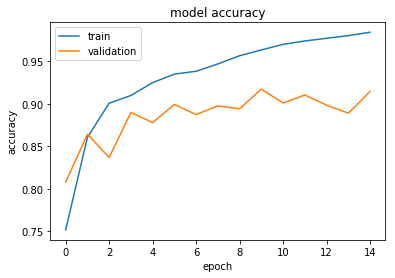

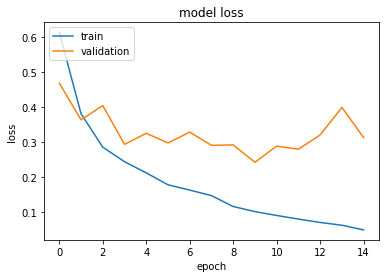

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*history.history['acc'][-1], 100*history.history['val_acc'][-1]))

Training accuracy: 98.40% / Validation accuracy: 91.45%


In [21]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,13,431,1))

In [22]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

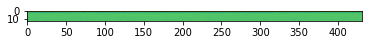

In [26]:
plt.imshow(X_train[10])

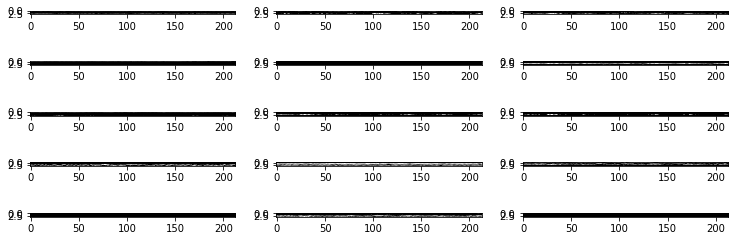

In [32]:
display_activation(activations, 3, 5, 3)

In [36]:
X_val = X_val.reshape(1170,13,431,1)

In [37]:
X_val.shape

(1170, 13, 431, 1)

In [38]:
Y_prediction = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

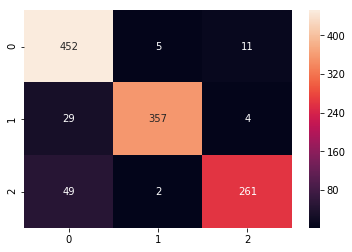

In [39]:
sns.heatmap(confusion_mtx, annot=True, fmt="d")

In [43]:
print("F1 Score: ", f1_score(Y_true, Y_pred_classes, average="macro"))
print("Precision Score: ", precision_score(Y_true, Y_pred_classes, average="macro"))
print("Recall Score: ", recall_score(Y_true, Y_pred_classes, average="macro")) 

F1 Score:  0.9135054424697749
Precision Score:  0.9264171977871731
Recall Score:  0.905911680911681


dtype('float64')

In [ ]:
X_train[0,:].reshape(1,-1)

In [ ]:
K.variable(value=X_train)

In [ ]:
# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# # Testing
# test = K.expand_dims(X_val, axis=-1)
# layer_outs = [func([test, 1.]) for func in functors]
# print(layer_outs)

In [ ]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
layer_output = get_3rd_layer_output([X_train[0,:].reshape(1,-1)])[0]

In [ ]:
intermediates = []
color_intermediates = []
for i in range(len(X_train)):
    output_class = np.argmax(y_train[i,:])
    intermediate_tensor = intermediate_tensor_function([X_train[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    if output_class == 0:
        color_intermediates.append("#0000ff")
    elif output_class == 1:
        color_intermediates.append("#ff0000")
    else:
        color_intermediates.append("#7fff00")

In [ ]:
tsne = TSNE(n_components=3, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

In [ ]:
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()